# Projet OT5: Parallélisation de micro-aevol

## Adrien Jaillet - Novembre 2022

### Présentation des fichiers

Le dossier est composé de plusieurs sous-dossier. Chaque sous-dossier correspon à une nouvelle version de micro-aevol. La version v0 correspond à la version initial. 

J'ai choisi d'axer ma parallélisation sur le GPU, car c'est ce qui m'interessait le plus.

### Configuration

Afin que les programmes puissent compiler sur votre machine, vous devez modifier mettre dans une variable d'environement nommé MICRO_AEVOL_PROJECT_DIRECTORY le chemin vers la racine du projet.

In [1]:
!export MICRO_AEVOL_PROJECT_DIRECTORY=/home/ajaillet/Documents/5IF/OT5/micro-aevol2-master
!printenv MICRO_AEVOL_PROJECT_DIRECTORY

/home/ajaillet/Documents/5IF/OT5/micro-aevol2-master


### V0: Vérification de la cohérence des résultats CPU / GPU et comparaison des résultarts

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été érronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [3]:
import subprocess
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v0/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

CMake Warning (dev) in CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "micro_aevol_gpu".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "cuda_micro_aevol".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES no

Num steps set to  10
All old files are removed
V0 CPU compiled and copied to experiment_cpu_v0
V0 CPU executed and fitness result written in ./experiment_cpu_v0/result_fitness.csv
V0 GPU compiled and copied to experiment_to_challenge
V0 GPU executed and fitness result written in ./experiment_to_challenge/result_fitness_gpu.csv
 OK: We got the same results



#### Analyse des performances

In [8]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000]
nbValues = 10
values = {"v0_cpu": [], "v0_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_both.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_gpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v0.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
version = "v0_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
f.close()

print("Done")

CMake Warning (dev) in CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "micro_aevol_gpu".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "cuda_micro_aevol".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES no

KeyboardInterrupt: 

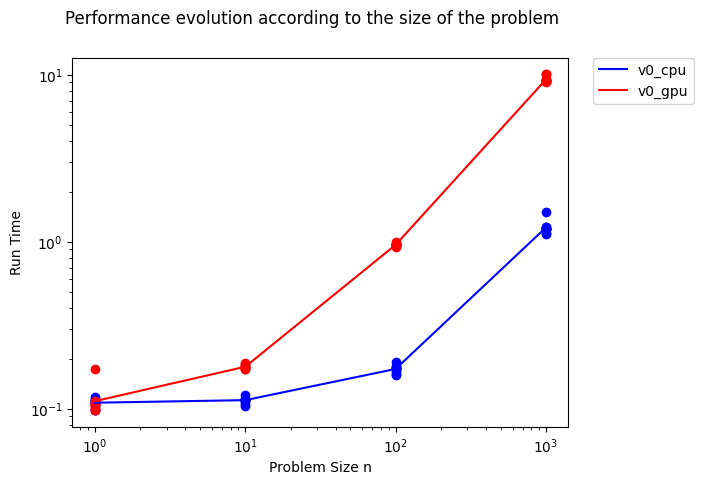

In [4]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd
import os

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v0_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v0_gpu" : "red"}
versions = ["v0_cpu", "v0_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Bla Bla Bla

### V1

Premièrement, en utilisant le GPU, nous remarquons que nous passons beaucoup de temps dans le nettoyage des données à la fin du programme. (quasiment 3 secondes)
![PB1](images/problems_clean.png)

En parallélisant cette partie, nous gagnons déjà quasiment 3 secondes sur le résultats.
![PB2](images/after_first_clean.png)


Ensuite nous remarquons que nous passons une grosse partie de notre temps dans la fonction "sparse_meta" (30%), nous allons donc paralélliser cette fonction.
![PB3](images/pb_sparse_meta_data.png)

En parallélisant cette partie, nous réduisons le temps passé (qui était de 30%) à 10% environ.
![PB4](images/after_parallelization_sparse.png)

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été érronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [5]:
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v1/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

CMake Warning (dev) in CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "micro_aevol_gpu".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "cuda_micro_aevol".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES no

Num steps set to  10
All old files are removed
V0 CPU compiled and copied to experiment_cpu_v0
V0 CPU executed and fitness result written in ./experiment_cpu_v0/result_fitness.csv
V1 GPU compiled and copied to experiment_to_challenge
V1 GPU executed and fitness result written in ./experiment_to_challenge/result_fitness_gpu.csv
 OK: We got the same results



#### Analyse des performances

In [ ]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000]
nbValues = 10
values = {"v0_cpu": [], "v0_gpu": [], "v1_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_both.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_gpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v1/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v1_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v1.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
version = "v0_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
version = "v1_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
f.close()

print("Done")

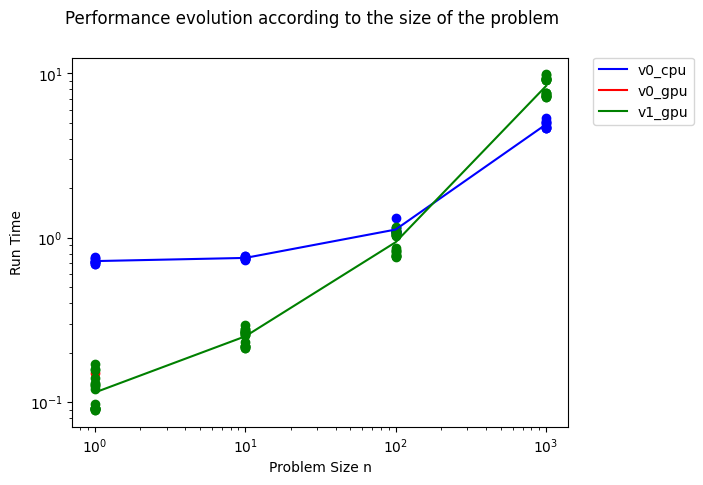

In [39]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v1_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v0_gpu" : "red", "v1_gpu": "green"}
versions = ["v0_cpu", "v0_gpu", "v1_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Nous remarquons que notre nouvelle version GPU est meilleure que la version CPU de base jusqu'à ce que l'on dépasse les n=100. Cela est dû à la mauvaise latence de notre code en GPU. Dans la fonction "evaluate_population", nous nous synchronisons tous les blocks à chaque fin de fonction, ce qui rajoute énormément de temps de latence. Nous allons donc enlever ces synchonisation dès que nous le pouvons. Nous gardons une synchronisation avant la fonction "clean_metadata" et la fonction "gather_genes" car ces deux fonctions sont les seuls qui n'utilise pas un block par individu. 

#### Cohérence des résultats

Le script suivant vérifie que les résultats n'ont pas été érronés durant les modifications. Les compilations se refont si besoin au cours des scripts pythons:

In [7]:
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = 10

os.chdir(ABSOLUTE_PATH)

args = ("python3", "v2/result_comparison/comparison.py", str(NUM_STEPS))
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

print(popen.stdout.read().decode("utf-8"))

CMake Warning (dev) in CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "micro_aevol_gpu".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "cuda_micro_aevol".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES no

Num steps set to  10
All old files are removed
V0 CPU compiled and copied to experiment_cpu_v0
V0 CPU executed and fitness result written in ./experiment_cpu_v0/result_fitness.csv
V2 GPU compiled and copied to experiment_to_challenge
V2 GPU executed and fitness result written in ./experiment_to_challenge/result_fitness_gpu.csv
 OK: We got the same results



#### Récupération des résultats

In [12]:
import os
import subprocess

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
NUM_STEPS = [1, 10, 100, 1000]
nbValues = 10
values = {"v0_cpu": [], "v1_gpu": [], "v2_gpu": []}

os.chdir(ABSOLUTE_PATH)

# Compilation phase
if not os.path.exists("v0/experiments"):
    os.mkdir("v0/experiments")

os.chdir("v0/experiments")


# Getting the values
args = ("sh", "../bin/compile_cpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_cpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v0_cpu"].append((n, val))

os.chdir(ABSOLUTE_PATH)

os.chdir("v1/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v1_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

os.chdir("v2/experiments")
args = ("sh", "../bin/compile_gpu.sh")
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()

for n_steps in range(0, nbValues):
    for n in NUM_STEPS:
        args = ("./micro_aevol_gpu", "-n", str(n))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        val = float(popen.stdout.read().decode("utf-8").split('\n')[-2])
        values["v2_gpu"].append((n, val))


os.chdir(ABSOLUTE_PATH)

f = open("stats_v0_v1_v2.csv", "w")
version = "v0_cpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) + ", " + str(val[1]) + "\n")
    
version = "v1_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
version = "v2_gpu"
for val in values[version]:
    f.write(version + ', ' + str(val[0]) +", " + str(val[1]) + "\n")
    
f.close()

print("Done")

CMake Warning (dev) in CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "micro_aevol_gpu".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES not allowed.  Run "cmake --help-policy CMP0104"
  for policy details.  Use the cmake_policy command to set the policy and
  suppress this warning.

  CUDA_ARCHITECTURES is empty for target "cuda_micro_aevol".
This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Warning (dev) in cuda/CMakeLists.txt:
  Policy CMP0104 is not set: CMAKE_CUDA_ARCHITECTURES now detected for NVCC,
  empty CUDA_ARCHITECTURES no

Done


Analyse des performances:

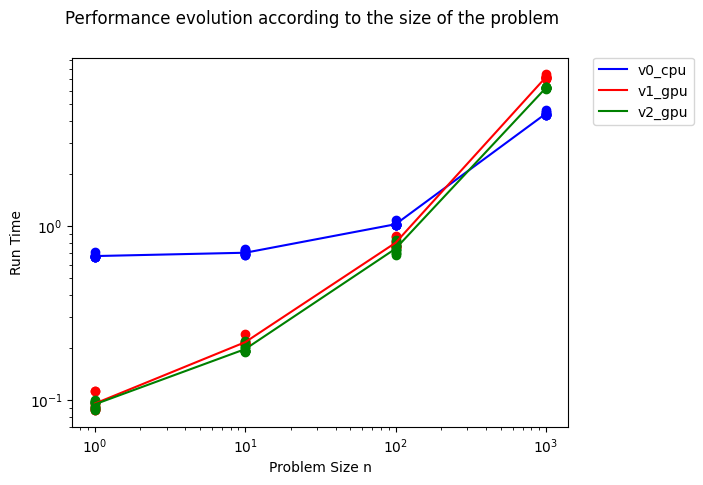

In [13]:
# Ploting the values
import matplotlib.pyplot as plt
import pandas as pd

ABSOLUTE_PATH = os.environ.get('MICRO_AEVOL_PROJECT_DIRECTORY')
os.chdir(ABSOLUTE_PATH)

df = pd.read_csv('stats_v0_v1_v2_fixed.csv',header=None,names=['version','n', 'runtime'],dtype={
                     'version': str,
                     'n': int,
                     'runtime' : float
                 })

color_version = {"v0_cpu" : "blue", "v1_gpu" : "red", "v2_gpu": "green"}
versions = ["v0_cpu", "v1_gpu", "v2_gpu"]

fig, (ax1) = plt.subplots(1)
fig.suptitle('Performance evolution according to the size of the problem')


for version in versions:
    df_plot = df[(df['version'] == version)]
    mean_stats = df_plot.groupby(['version', 'n']).mean().reset_index()
    
    
    ax1.plot(mean_stats['n'], mean_stats['runtime'],linestyle="solid",color=color_version[version], label=version)
    ax1.scatter(df_plot['n'], df_plot['runtime'],color=color_version[version])
    


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Problem Size n')
ax1.set_ylabel('Run Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()